In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import time
import numpy as np
import unicodedata
import re

We will use the same data as Lab 5

# Preprocessing

The complete preprocessing is identic to Lab 5!

In [ ]:
!wget --quiet http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

lines = open('deu.txt', encoding='UTF-8').read().strip().split('\n')

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [ ]:
def preprocess_sentence(w):
  w = w.lower().strip()
  # This next line is confusing!
  # We normalize unicode data, umlauts will be converted to normal letters
  w = w.replace("ß", "ss")
  w = ''.join(c for c in unicodedata.normalize('NFD', w) if unicodedata.category(c) != 'Mn')

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
english = []
german = []
for line in lines:
  en = line.split('\t')[0]
  de = line.split('\t')[1]
  english.append(preprocess_sentence(en))
  german.append(preprocess_sentence(de))

In [ ]:
NUM_EXAMPLES = 30000
english = english[:NUM_EXAMPLES]
german = german[:NUM_EXAMPLES]

In [ ]:
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
en_tokenizer.fit_on_texts(english)

data_en = en_tokenizer.texts_to_sequences(english)
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en, padding='post')

ge_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
ge_tokenizer.fit_on_texts(german)

data_ge = ge_tokenizer.texts_to_sequences(german)
data_ge = tf.keras.preprocessing.sequence.pad_sequences(data_ge,padding='post')

In [ ]:
X_train,  X_test, Y_train, Y_test = train_test_split(data_en, data_ge, test_size=0.2)

BATCH_SIZE = 64
BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

In [ ]:
def max_len(sentence):
    return max(len(s) for s in sentence)

max_length_input = max_len(data_en)
max_length_output = max_len(data_ge)  
input_vocab_size = len(en_tokenizer.word_index) + 1  
target_vocab_size = len(ge_tokenizer.word_index) + 1

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, 
                                                                                            drop_remainder=True) 

Now starts the fun!

# Pointwise FFN

In [ ]:
def pointwise_ffn(embedding_dims, expanded_dims):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(expanded_dims, activation='relu'),  
      tf.keras.layers.Dense(embedding_dims)  
  ])

# Masking

We want to have a binary mask with ones meaning that the element should not be taken into consideration. We neeed a mask for padding and another one for the masked multi-head attention layer 

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits. Tensor sizes are always a pain...
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

[tf.linalg.band](https://www.tensorflow.org/api_docs/python/tf/linalg/band_part): With parameters -1 and 0 it creates an triangular matrix with ones in the diagonal and below

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
print(x)
print(temp)

tf.Tensor([[0.48979354 0.64737976 0.04136157]], shape=(1, 3), dtype=float32)
tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


In [ ]:
def create_masks(input, target):
  # Encoder padding mask
  encoder_padding_mask = create_padding_mask(input)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  decoder_padding_mask = create_padding_mask(input)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
  decoder_target_padding_mask = create_padding_mask(target)
  combined_mask = tf.maximum(decoder_target_padding_mask, look_ahead_mask)
  
  return encoder_padding_mask, decoder_padding_mask, combined_mask

# Self-Attention

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [ ]:
def calculate_self_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_scores = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_scores += (mask * -1e9)  

  # softmax is normalized on the last axis (len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_scores, axis=-1)  

  output = tf.matmul(attention_weights, v)  

  return output

# Multi-head Attention

1. Dense layers and split into heads.
2. Self Attention 
3. Concatenation of heads.
4. Final linear layer.

In [ ]:
num_heads = 8
embedding_dims = 128

In [ ]:
q = tf.random.uniform((BATCH_SIZE, 60, embedding_dims))
print(q.shape)
q_head = tf.reshape(q, (BATCH_SIZE, -1, num_heads, embedding_dims // num_heads))
print(q_head.shape)
q_projected = tf.transpose(q_head, perm=[0, 2, 1, 3])
print(q_projected.shape)

(64, 60, 128)
(64, 60, 8, 16)
(64, 8, 60, 16)


A -1 passed in the 'shape' argument from tf.reshape says "Whatever fits".

Read about transposing tensors with permutations [here](https://www.tensorflow.org/api_docs/python/tf/transpose). Transpose in higher dimension than 2 is confusing! Use a piece of paper and draw the matrices to make it more understandable.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, embedding_dims, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.embedding_dims = embedding_dims
    self.depth = embedding_dims // num_heads
    
    self.wq = tf.keras.layers.Dense(embedding_dims)
    self.wk = tf.keras.layers.Dense(embedding_dims)
    self.wv = tf.keras.layers.Dense(embedding_dims)
    
    self.dense = tf.keras.layers.Dense(embedding_dims)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, embedding_dims)
    k = self.wk(k)  
    v = self.wv(v)  
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  
    
    # self_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    self_attention = calculate_self_attention(q, k, v, mask)
    
    self_attention = tf.transpose(self_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)

    concat_attention = tf.reshape(self_attention, 
                                  (batch_size, -1, self.embedding_dims))  # (batch_size, seq_len, embedding_dims)

    output = self.dense(concat_attention)
        
    return output

# Encoder Layer

Input and output of the encoder Layer has the same dimensions

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dims, num_heads, expanding_dims, rate=0.1):
    super().__init__()

    self.mha = MultiHeadAttention(embedding_dims, num_heads)
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffn = pointwise_ffn(embedding_dims, expanding_dims)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, training, padding_mask):

    attn_output = self.mha(x, x, x, padding_mask)  
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  
    
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)   # (batch_size, input_seq_len, embedding_dims)
    
    return out2

# Decoder Layer

Almost the same as Encoder Layeer, with an extra MultiHead Attention Layer, taking the encoder output into consideration, and having the look_ahead_mask)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, embedding_dims, num_heads, expanded_dims, rate=0.1):
    super().__init__()

    self.mha1 = MultiHeadAttention(embedding_dims, num_heads)
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.mha2 = MultiHeadAttention(embedding_dims, num_heads)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffn = pointwise_ffn(embedding_dims, expanded_dims)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6) 
    
  def call(self, x, encoder_output, training, padding_mask, look_ahead_mask):

    attn1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2 = self.mha2( encoder_output, encoder_output, out1, padding_mask)  
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  
    
    ffn_output = self.ffn(out2)  
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, embedding_dims)
    
    return out3

# Positional Encoding

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, dimensions):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(dimensions)[np.newaxis, :],
                          dimensions)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


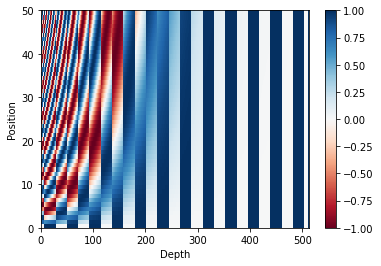

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Encoder (Input Embeddings + Encoder Layers)

The Encoder consists of:

1. Input Embedding
2. Positional Encoding
3. Encoder layers



In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dims, num_heads, expanded_dims, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embedding_dims)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            embedding_dims)
    
    self.dropout = tf.keras.layers.Dropout(rate)

    self.encoder_layers = [EncoderLayer(embedding_dims, num_heads, expanded_dims, rate) 
                       for i in range(num_layers)]
  
    
        
  def call(self, x, training, padding_mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.embedding_dims, tf.float32)) # Technicality that  is used in the original paper
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.encoder_layers[i](x, training, padding_mask)
    
    return x  # (batch_size, input_seq_len, embedding_dims)

# Decoder (Input Embeddings + Decoder Layers)

The Decoder consists of:

1. Output Embedding
2. Positional Encoding
3. N decoder layers

Almost the same as Encoder! Few changes: 

target_vocab_size instead of input, DecoderLayer instead of EncoderLayer, and 2 extra parameters (encoder_output and look_ahead_mask )

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, embedding_dims, num_heads, expanded_dims, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, embedding_dims)
    self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dims)
    
    self.decoder_layers = [DecoderLayer(embedding_dims, num_heads, expanded_dims, rate) 
                       for i in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, encoder_output, training, 
           padding_mask, look_ahead_mask):

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.embedding_dims, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.decoder_layers[i](x, encoder_output, training,
                                padding_mask, look_ahead_mask)
  
    return x  # (batch_size, target_seq_len, d_model)

# Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, embedding_dims, num_heads, expanded_dims, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers, embedding_dims, num_heads, expanded_dims, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, embedding_dims, num_heads, expanded_dims, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, input, target, training, encoder_padding_mask, 
           decoder_padding_mask, look_ahead_mask):

    encoder_output = self.encoder(input, training, encoder_padding_mask)  # (batch_size, inp_seq_len, embedding_dims)
    
    
    dec_output = self.decoder(target, encoder_output, training, decoder_padding_mask, look_ahead_mask)
    # (batch_size, target_seq_len, embedding_dims)

    final_output = self.final_layer(dec_output)  # (batch_size, target_seq_len, target_vocab_size)
    
    return final_output

In [ ]:
num_layers = 4
expanded_dims = 512

transformer = Transformer(num_layers, embedding_dims, num_heads, expanded_dims,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size)

# Run the Model

Same loss function as in Lab 5

In [ ]:
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = loss * mask
  loss = tf.reduce_mean(loss)
  return loss

The original Transformer paper uses a custom learning rate scheduler :
$$lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})$$

I tried it without the scheduler and the training stops learning very quickly. (This configuration is the most **crucial** one for succesfully training the Transformer)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, embedding_dims, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.embedding_dims = embedding_dims
    self.embedding_dims = tf.cast(self.embedding_dims, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.embedding_dims) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(embedding_dims)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Almost same training steps as in Lab 5. But using the Transformer instead of the encoder/decoder

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()
  epoch_loss = 0

  for (batch, (input, target)) in enumerate(dataset.take(steps_per_epoch)):
    decoder_input = target[ : , :-1 ] # ignore <end> token
    real = target[ : , 1: ]           # ignore <start> token
    
    enc_padding_mask, dec_padding_mask, combined_mask = create_masks(input, decoder_input)
    
    with tf.GradientTape() as tape:
      predictions = transformer(input=input, target=decoder_input, 
                                  training=True, 
                                  encoder_padding_mask=enc_padding_mask, 
                                  decoder_padding_mask=dec_padding_mask,
                                  look_ahead_mask=combined_mask)
      batch_loss = loss_function(real, predictions)


    gradients = tape.gradient(batch_loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    epoch_loss += batch_loss  

    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f}'.format(
          epoch + 1, batch, batch_loss.numpy()))
    
  print ('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                                epoch_loss / steps_per_epoch))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4174
Epoch 1 Batch 100 Loss 4.1914
Epoch 1 Batch 200 Loss 3.5444
Epoch 1 Batch 300 Loss 2.9483
Epoch 1 Loss 3.5660
Time taken for 1 epoch: 130.3606677055359 secs

Epoch 2 Batch 0 Loss 2.5875
Epoch 2 Batch 100 Loss 2.2671
Epoch 2 Batch 200 Loss 1.8482
Epoch 2 Batch 300 Loss 1.8198
Epoch 2 Loss 2.0082
Time taken for 1 epoch: 128.74184775352478 secs

Epoch 3 Batch 0 Loss 1.6672
Epoch 3 Batch 100 Loss 1.5695
Epoch 3 Batch 200 Loss 1.5553
Epoch 3 Batch 300 Loss 1.4516
Epoch 3 Loss 1.5224
Time taken for 1 epoch: 128.02325439453125 secs

Epoch 4 Batch 0 Loss 1.3273
Epoch 4 Batch 100 Loss 1.2716
Epoch 4 Batch 200 Loss 1.2477
Epoch 4 Batch 300 Loss 1.2888
Epoch 4 Loss 1.3219
Time taken for 1 epoch: 128.3040976524353 secs

Epoch 5 Batch 0 Loss 1.1560
Epoch 5 Batch 100 Loss 1.1361
Epoch 5 Batch 200 Loss 1.1093
Epoch 5 Batch 300 Loss 1.0737
Epoch 5 Loss 1.1745
Time taken for 1 epoch: 128.03246974945068 secs

Epoch 6 Batch 0 Loss 1.0828
Epoch 6 Batch 100 Loss 1.0286
Epoch 6 B

# Translate

Again almost the same code as Lab 5, compare the differences!

In [ ]:
def translate(sentence, preprocess=True):
  if preprocess:
    sentence = preprocess_sentence(sentence)
    input = en_tokenizer.texts_to_sequences([sentence])
  else:
    input = sentence
  input = tf.convert_to_tensor(input)
  
  # as the target is German, the first word to the transformer should be the
  # German start token
  start_token = tf.convert_to_tensor([ge_tokenizer.word_index['<start>']])
  start_token = tf.expand_dims(start_token, 0)

  # And it should stop wiht the end token
  end_token = tf.convert_to_tensor(ge_tokenizer.word_index['<end>'])
  end_token = tf.expand_dims(end_token, 0)
  
  output = start_token
  for i in range(max_length_output):
    enc_padding_mask, dec_padding_mask, combined_mask, = create_masks(
                                                          input, output)
  
    predictions = transformer(input, 
                              output,
                              False,
                              enc_padding_mask,
                              dec_padding_mask,
                              combined_mask
                              )
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == end_token:
      result = tf.squeeze(output, axis=0)
      return ge_tokenizer.sequences_to_texts(output.numpy())[0]
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  result = tf.squeeze(output, axis=0)
  return ge_tokenizer.sequences_to_texts(output.numpy())[0]
translate("I love you")

'<start> ich liebe dich .'

In [ ]:
translate("I want to kiss you!")

'<start> ich mochte dich kussen !'

In [ ]:
translate("I played the piano today")

'<start> ich habe das klavier gespielt .'

In [ ]:
translate("The teacher was happy to train the language model")

'<start> der lehrer war glucklich .'

Same BLEU code

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

bleu_scores = []
smooth_fn = SmoothingFunction()

for input, target in zip(X_test, Y_test):
    original = ge_tokenizer.sequences_to_texts([target])[0]
    predicted = translate([input], preprocess=False)
    original = re.sub("(<end>)|(<start>)|\?|!|\.", "", original)
    predicted = re.sub("((<start>)|<end>)|\?|!|\.", "", predicted)
    original_tokens = original.strip().split(" ")
    predicted_tokens = predicted.strip().split(" ")
    score = sentence_bleu([original_tokens], predicted_tokens, 
                          smoothing_function=smooth_fn.method1)
    bleu_scores.append(score)

np.mean(np.array(bleu_scores)) * 100

33.880536735103796

The original Transformer paper used more tricks and higher dimensions:

*   For tokenization, it uses the very famous technique of [Byte-Encoding](https://leimao.github.io/blog/Byte-Pair-Encoding/). We will talk next class about this.
*   num_layers=6, embedding_dims = 512, expanded_dims = 2048
* The complete WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs
* The paper averages the last k checkpoints to create an ensembling effect. 



# Continue Learning

## Transformer Block for text classification

We are going to reuse the Multi-head layer and create a single Transformer block (**Using only the Encoder part**) to classify positive/negative IMDB reviews.

Same initialization as in Lab 4

In [ ]:
import tensorflow_datasets as tfds

train_data,  = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

max_sentence_size = 100
vocabulary_size = 10000

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTZCEEZ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTZCEEZ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTZCEEZ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vocabulary_size = 10000
sentence_size = 100
vectorize_layer = TextVectorization(max_tokens=vocabulary_size, output_sequence_length=sentence_size)
train_text = train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dims, num_heads, expanded_dims, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(embedding_dims, num_heads)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)

        self.ffn = pointwise_ffn(embedding_dims, expanded_dims)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x, None)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) 

This time around let's try very simple positional embeddings for learning purposes! Simply use the position of the word

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocabulary_size, embedding_dims):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(vocabulary_size, embedding_dims)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embedding_dims)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

To build neural network models, the middle point between the Sequential API and the Subclass API is the Functional API. It has the same idea of initializing the Layer and then calling it with the previous parameter, but without working with classes.

You need to specify input shapes!

In [ ]:
embedding_dims = 32  
num_heads = 2  
expanded_dims = 32  


inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.string)
vectorizer = vectorize_layer(inputs)
embedding_layer = TokenAndPositionEmbedding(max_sentence_size, vocabulary_size, embedding_dims)
x = embedding_layer(vectorizer)
transformer_block = TransformerBlock(embedding_dims, num_heads, expanded_dims)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy', 'Precision'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_data.batch(512), epochs=10, 
                    validation_data=validation_data.batch(512), 
                    callbacks=[early_stopping_cb])

Epoch 1/10
30/30 [==============================] - 16s 527ms/step - loss: 0.6632 - accuracy: 0.5937 - precision: 0.5912 - val_loss: 0.5770 - val_accuracy: 0.7331 - val_precision: 0.7797
Epoch 2/10
30/30 [==============================] - 15s 512ms/step - loss: 0.4691 - accuracy: 0.7926 - precision: 0.7917 - val_loss: 0.4569 - val_accuracy: 0.7836 - val_precision: 0.8753
Epoch 3/10
30/30 [==============================] - 15s 512ms/step - loss: 0.3272 - accuracy: 0.8654 - precision: 0.8674 - val_loss: 0.4048 - val_accuracy: 0.8244 - val_precision: 0.8294
Epoch 4/10
30/30 [==============================] - 15s 511ms/step - loss: 0.2405 - accuracy: 0.9096 - precision: 0.9104 - val_loss: 0.4394 - val_accuracy: 0.8222 - val_precision: 0.8086
Epoch 5/10
30/30 [==============================] - 15s 508ms/step - loss: 0.2261 - accuracy: 0.9153 - precision: 0.9097 - val_loss: 0.7121 - val_accuracy: 0.7346 - val_precision: 0.9213
Epoch 6/10
30/30 [==============================] - 15s 512ms/ste

In [ ]:
model.evaluate(test_data.batch(512))

49/49 [==============================] - 8s 170ms/step - loss: 0.4310 - accuracy: 0.8078 - precision: 0.8234


[0.4310370981693268, 0.8078399896621704, 0.823361337184906]

Same accuracy as the simple FNN from Lab 4. Why?? Back then we used pretrained GloVe embeddings. Here without pre-trained embeddings in few epochs we get the same results. Actually not bad at all for a baby transformer.

How to make it better? Use pre-trained Transformer embeddings from a huge model (GPT/BERT...) + a simple FNN.

We will do this in the next two weeks, let's see if we get lucky and get better results

Note: We included the padded tokens in the attention layer. It would be better to mask them as we did in the Transformer code. Try to implement it and see if the accuracy increases!